# Selección de clientes RandomSampling para métodos basado en recursos

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método de selección de _baseline_ RandomSampling aplicado a un entorno de clientes heterogéneos en cuanto a datos y recursos computacionales y de comunicación. Es por tanto el método _baseline_ para la comparación entre los algoritmos basados en recursos.
> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/1905.07210

In [33]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is installed.


In [34]:
# install Torchsummary if not installed
try:
    import torchsummary
    print("torchsummary is installed.")
except:
    print("torchsummary is not installed.\nInstalling dependency torchsummary...")
    !pip install torchsummary

torchsummary is installed.


In [35]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [36]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda'

# Cargar datasets - MNIST, CIFAR-10


## Distribución de los datos

Para la distribución de los datos preparamos una federación para ambos datasets en el que simulamos clientes __heterogéneos__ en cuestión tanto de clases como del tamaño de sus conjuntos de datos. Nos basamos en la federación que realizan en [1].

Para poder crear un escenario de clientes heterogéneos, suponemos un dataset de $10$ clases que puede ser cualquiera de los que estamos utilizando (MNIST o CIFAR-10). Luego realizamos una federación con la siguiente descripción de [1]: _"muestrear dos/diez clases para cada cliente para CIFAR-10/CIFAR-100$^1$; Luego, para cada cliente $i$ y una clase seleccionada $c$, muestreamos $\alpha_{i,c} \sim U(.4, .6)$, y lo asignamos con $\frac{\alpha_{i,c}}{\sum_j{\alpha_{j,c}}}$ de los ejemplos para esta clase. Repetimos lo anterior para $10, 50$ y $100$ clientes."_ De esta forma, creamos una distribución de datos en el que cada cliente tendrán un número de clases diferente al resto y con diferentes tamaños, formando una distribución no-IID de datos.

> $^1$ En nuestro caso solo será para CIFAR-10 y MNIST, es decir, suponemos siempre $10$ clases.
>
> [1] https://arxiv.org/abs/2103.04628.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Para poder federar EMNIST, debemos de crear una configuración con `FedDatasetConfig` para poder especificar como queremos distribuir los datos y a cuántos nodos queremos federarlo y luego utilizar la clase `FedDataDistribution` para poder crear el dataset federado. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [37]:
import math
import numpy as np

from copy import deepcopy
from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 1000

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair (https://arxiv.org/abs/2404.06127)
num_classes = 10
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of MNIST
flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

Realizamos la misma serie de operaciones que con EMNIST, para el mismo número de clientes, $K = 1000$ (sin contar el servidor). Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [38]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

K_cifar = 1000

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

num_classes = 10

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

Files already downloaded and verified
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ unidades la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [39]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [40]:
import torchsummary

torchsummary.summary(MLP((28, 28), 128).to(device), (1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional usada en la configuración experimental de HybridFL, que consiste en una CNN estándar que consiste en _"seis capas de convolución de 3 × 3 (con 32, 32, 64, 64, 128 y 128 canales, cada una de las cuales se activaba utilizando ReLU y se normalizaba por lotes, y cada dos de las cuales estaban seguidas de un max pooling de 2 × 2), seguidas de tres capas completamente conectadas (con 512 y 192 unidades activadas utilizando ReLU y otras 10 unidades activadas utilizando soft-max)."_ [1].

> [1] https://arxiv.org/abs/1905.0721
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [41]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture taken from HybridFL experimental setting:
    - https://arxiv.org/abs/1905.07210
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.num_classes = output_dim

        # Pooling Layer (applied every two layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First layer
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, 3, 1
        )

        # Second layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        output_w_2, output_h_2 = self.__conv_output_dims(
            output_w_1, output_h_1, 3, 1
        )

        # after pooling
        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_2, output_h_2, 2, 2
        )

        # Third layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, 3, 1
        )

        # Fourth layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        output_w_4, output_h_4 = self.__conv_output_dims(
            output_w_3, output_h_3, 3, 1
        )

        # after pooling
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_4, output_h_4, 2, 2
        )

        # Fifth layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        output_w_5, output_h_5 = self.__conv_output_dims(
            output_w_4, output_h_4, 3, 1
        )

        # Sixth layer
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        output_w_6, output_h_6 = self.__conv_output_dims(
            output_w_5, output_h_5, 3, 1
        )

        # after pooling
        output_w_6, output_h_6 = self.__pool_output_dims(
            output_w_6, output_h_6, 2, 2
        )

        # Fully-Connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int(output_w_6 * output_h_6 * 128), out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # softmax applied on loss function
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

In [42]:
torchsummary.summary(CNN(in_channels=3, output_dim=10).to(device), (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

# Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

## Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [43]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
## Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [44]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    print(server_flex_model.keys())
    return copy.deepcopy(server_flex_model)

## Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [45]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


## Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [46]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

## Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [47]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        weights_per_layer = weights_per_layer.clone().detach().float().requires_grad_(True)   # ensure is floating-point type
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [48]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

## Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [49]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

## Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [50]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

## Inicialización de los recursos de los clientes

El siguiente paso para construir este entorno de simulación es determinar los recursos iniciales que tendrán los clientes. Los clientes son en esencia dispositivos (e.g. móviles, coches inteligentes, SmartTVs, ...) que tienen ciertas especificaciones que definen los recursos que posee. HybridFL así como FedCS, consideran dos tipos de recursos en los dispositivos:

- Recursos de comunicación inalámbrica: que influye directamente en la comunicación entre el servidor y los clientes (e.g ancho de banda en red, congestión de la red, _Resource Blocks_ $^1$). Podemos determinar la capacidad de comunicación de los clientes con el servidor en __cuánta cantidad de información es capaz de enviar en un segundo__, a lo que también se le conoce como _throughput_, y utilizamos como unidades estándar Mbit/s.

- Recursos computacionales: que influye en las actualizaciones del modelo en los clientes. HybridFL implementa el concepto de entrenamiento centralizado en el servidor; por tanto, como una suposición estándar en FL, suponemos que el servidor central tiene suficiente potencia computacional como para sobrepasar a los clientes en velocidad por la existencia de _stragglers_ [4]. Por lo que el tiempo de actualización de reloj del servidor la suponemos __nula o despreciable__. Podemos determinar la capacidad computacional de los clientes como __el número de ejemplos que puede procesar en un segundo__ actualizar el modelo [1].

- Permiso de subida de datos: este tipo de recurso, propio de HybridFL, es básicamente el permiso del cliente de subir sus datos al servidor, cuyo número de clientes se asume muy pequeño (menos del $\%1$ como mínimo [1]).

Por tanto, para poder muestrear en cada ronda de FL los recursos de los clientes, inicializamos primero las capacidades computacionales y de comunicación medias de cada cliente, de manera que en cada ronda se puedan samplear con una distribución Gaussiana truncada [5] como lo hacen los autores en [1]. Concretamente, el _throughput_ medio de los clientes se ha extraído de los experimentos hechos en un entorno simulado de comunicaciones inalámbricas de [1], en el que concluyeron que los clientes presentaban un _throughput_ de $\theta^{\text{avg}}_{k} = 1.4$ Mbit/s de media y un máximo de hasta $8.6$ Mbit/s, que resultan valores realistas en una red LTE. En cuanto a la capacidad computacional, se muestrea el número de datos procesados por segundo en entrenamiento de una distribución uniforme $\gamma^{\text{avg}}_{k} \sim U(10, 100)$. Finalmente, se elige de forma aleatoria y uniforme si el cliente $k$ permite su subida de datos en un ratio de $r_{\text{UL}} = 0.01$.

> $^1$ Aunque el número de bloques de recursos o RBs (la unidad mínima de ancho de banda en LTE [3]) puede influir significativamente en el tiempo de comunicación entre el servidor y los clientes, seguiremos la suposición de [2] por el que los RBs asignados a cada cliente son los mismos para todos, de esta manera solo nos preocupan factores más fluctuantes en casos reales como el ancho de banda.
>
> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333
>
> [3] _S. Sesia, M. Baker, and I. Toufik, LTE-the UMTS Long Term Evolution: From Theory to Practice. John Wiley & Sons, 2011_
>
> [4] G. Wang, C. Zhao, Q. Qi, R. Han, L. Bai and J. Choi, "Efficient Federated Learning via Joint Communication and Computation Optimization," in IEEE Transactions on Vehicular Technology, doi: 10.1109/TVT.2024.3379742.
>
> [5] https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [51]:
from copy import deepcopy

# ratio of clients that permit their data to be uploaded
DEFAULT_R_UPLOAD = 0.05

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    r_upload = kwargs["r_upload"] if "r_upload" in kwargs else DEFAULT_R_UPLOAD

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < r_upload

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    if data_upload:
        client_flex_model["public_data"] = client_data

## Petición de recursos

A continuación, implementamos la función `resource_request` en la que el servidor/agregador comunica a $\lceil K \times C \rceil$ clientes (siendo $K$ el total de clientes y $C$ la fracción de clientes a seleccionar por ronda) seleccionados aleatoriamente, a notificarle de los recursos que poseen para la ronda actual, así como notificarle si permiten su subida de datos al servidor. Esta tarea se realizará de la siguiente manera:

1. El servidor inicializará en su modelo de FLEX, un diccionario para cada recurso e información adicional, en el que las claves de los mismos será el identificador del cliente en cuestión.
2. Para cada cliente, se recuperará los valores medios de las capacidades computacionales (el número de ejemplos procesados por unidad de tiempo) y de comunicación (_throughput_), así como también si permiten su subida de los datos.
    - Con esta información, para el cliente en cuestión, se muestrea la capacidad computacional y de comunicación para la ronda actual de una distribución normal truncada (usamos la librería de `scipy` [1] para muestrear aleatoriamente de esta distribución) con los valores medios recuperados de los clientes $^1$. Para el muestreo de la distribución normal truncada se usa una variancia para ambos tipos de recursos de $r_{\text{var}} = 0.2$.
    - Finalmente, con los recursos muestreados para la ronda actual, se pueden calcular los tiempos estimados de actualización y subida: $t^{\text{UL}}_k$ y $t^{\text{UD}}_k$ respectivamente. Que se usarán tanto para la selección de clientes y de datos como para el entrenamiento y subida de modelos agendados.

Definimos además una función `get_model_size` que calcula el tamaño en bytes de un modelo de aprendizaje. Esto nos servirá para estimar el tiempo que tarda un cliente con cierto _throughput_ en subir un modelo mediante la siguiente formula:
$$t_{k}^{\text{UL}} = D_m / \theta_k^{(t)}$$

siendo $D_m$ el tamaño en Mbit del modelo, y $\theta_k^{(t)}$ el _throughput_ del cliente $k$ en la ronda $t$.

El tiempo estimado en actualizar un modelo en un cliente $k$ (i.e. entrenar un modelo) se calcula con la siguiente formula:
$$t_k^{\text{UD}} = \frac{E \times N_k}{\gamma_k^{(t)}}$$

siendo $E$ el número de épocas de entrenamiento, $N_k$ el número de ejemplos que posee el cliente $k$ y $\gamma_k^{(t)}$ el número de ejemplo procesados por unidad de tiempo para entrenar el modelo en el cliente $k$ en la ronda $t$.

> $^1$ Nótese que conceptualmente, este muestreo de la capacidad de comunicación y computacional del cliente es lo que este último realmente notifica al servidor y no sus valores medios.
>
> [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

In [52]:
import sys
import torch.nn as nn

def get_model_size(model: nn.Module) -> int:
    """
    Get the size in bytes of a PyTorch learning model.
    """
    total_size = 0
    for param in model.parameters():
        total_size += param.numel() * param.element_size()

    return int(total_size)

In [53]:
from typing import List
from scipy.stats import truncnorm

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5

    # get model size in bytes
    if "model_size" in agg_model.keys():
        model_size = agg_model["model_size"]
    else:
        model_size = get_model_size(agg_model["model"])

        # store model size in server model
        agg_model["model_size"] = model_size


    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["client_t_update"] = {}
    agg_model["client_t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["client_n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (epochs * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (model_size * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["client_t_update"][k] = t_update
        agg_model["client_t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"]

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["client_n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

## Distribución del modelo global

Redefinimos la subrutina de `copy_server_model_to_clients` visto en la configuración básica, para copiar solo la información que deben de compartir los clientes con el servidor, es decir, no debemos distribuir la información almacenada propia del servidor a los clientes y solo la que nos interesa. Esto viene a darse porque FLEX por defecto copia el modelo del servidor entero, y por tanto se copiaría los datos de los clientes $D_u$, información de los recursos de todos los clientes, etc.

Para solo distribuir la información que nos interesa a los clientes, distribuimos toda la información del servidor para las claves que estén en la lista de claves de distribución (_white list_).

In [54]:
from flex.pool import deploy_server_model
import copy

white_list = [
    "model",
    "criterion",
    "optimizer_func",
    "optimizer_kwargs"
]

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    white_listed = {key: value for key, value in server_flex_model.items() if key in white_list}
    return copy.deepcopy(white_listed)

Creamos una subrutina del servidor para poder simular el tiempo de distribución de los modelos a los clientes. Esta función pretende ser ejecutada _luego_ o _antes_ de copiar el servidor del modelo a los clientes.

In [55]:
import time
from tqdm import tqdm
from flex.pool import FlexPool
from flex.data import Dataset

def scheduled_model_distribution(agg_model: FlexModel, _: Dataset, **kwargs):
    # get model size
    model_size = agg_model["model_size"]

    # get selected clients
    S: set = kwargs["S"]

    # get client throughputs
    thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # compute Time of Distribution
    t_dist = T_model_dist(model_size, thr)

    # simulate Time of Distribution of the model by sleeping
    with tqdm(total=t_dist, desc="Distributing model...") as pbar:
        interval = 0.1
        for _ in range(int(t_dist / interval)):
            time.sleep(interval)
            pbar.update(interval)

## Actualización y subida del modelo agendado

Como hemos explicado anteriormente, para simular el tiempo que se estima en la actualización del modelo en los clientes, definimos la función de entrenamiento `scheduled_train` el cual entrena de la manera convencional que hemos visto en la configuración básica del entorno FL, pero esta vez, el tiempo transcurrido de esta función está sujeto a cumplir el tiempo de actualización para ese cliente como mínimo. De manera que se refleje el impacto de la selección de tal cliente en la duración total del entrenamiento del modelo global.

Los clientes cuando terminan de entrenar su modelo, inmediatamente lo suben al servidor, por lo que también simularemos la subida agendada del modelo actualizado por el cliente en esta función simplemente _durmiendo_ el hilo de ejecución sobre su tiempo de subida $t^{UL}_k$.

In [56]:
def T_model_dist(model_size: int, throughputs: list):
    """
    Computes the estimated time it takes to distribute the model to all clients synchronically.

    If throughputs is empty, then time is 0 (no clients to distribute to).
    """
    if not throughputs:
        return 0

    res = (model_size * 8) / (min(throughputs) * 1_000_000)
    return res

In [57]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get scheduled update and upload time
    t_update = client_flex_model["t_update"]
    t_upload = client_flex_model["t_upload"]

    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating and uploading time by sleeping
    time.sleep(max(0, t_update - training_time) + t_upload)

El hilo de ejecución de los clientes se realiza en manera paralela y no secuencial tanto para la actualización de los modelos como su subida. Sin embargo, FedCS (y por tanto HybridFL) establece que las subidas de los modelos se realizan de manera síncrona y secuencial; por tanto, para simular el tiempo que debería durar la actualización y subida de los modelos vamos a definir una función en la que el servidor _duerme_ su hilo de ejecución por el tiempo necesario para simular la actualización paralela y la subida secuencial de los modelos, es decir, el tiempo transcurrido $\Theta_{S_t}$ [1]. En caso de que la ejecución en paralelo haya tomado más tiempo que $\Theta_{S_t}$, simplemente no dormimimos el hilo de ejecución.

> [1] Detalles en cómo calcular $\Theta_{S_t}$ en https://arxiv.org/abs/1804.08333.

In [58]:
import time
from flex.pool import FlexPool
from flex.data import Dataset

def simulate_model_update_upload(server_model: FlexModel, _: Dataset, **kwargs):

    # function to compute the time elapsed of clients parallel training and sequential upload
    def compute_simulation_time(S: list, elapsed_time=0):
        k = S[0]
        theta = elapsed_time + server_model["client_t_upload"][k] + max(0, server_model["client_t_update"][k] - elapsed_time)

        if len(S) == 1:
            return theta

        return compute_simulation_time(S[1:], elapsed_time=theta)

    # get clients indices
    S = list(kwargs["S"])

    # get total upload time
    elapsed_training_time = kwargs["training_time"]

    # compute the time of sequential model uploads and parallel updates
    sim_time = compute_simulation_time(S)

    # sleep for the difference between the parallel and sequential total times
    time_to_sleep = sim_time - elapsed_training_time

    if time_to_sleep > 0:
        time.sleep(time_to_sleep)

## Recolección de las actualizaciones de los modelos

Por último cambiamos la función de obtención y agrupación de los pesos de los clientes para también incluir también los del servidor.

In [59]:
import time
import torch
import numpy as np

def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel], **kwargs):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []

    # collect clients weights
    for k in clients_flex_models:
        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

## Entrenamiento paralelo de los modelos

Cuando no tenemos restricciones de tiempo ni fases agendadas, es viable realizar las actualizaciones locales de los clientes de forma _iterativa_, i.e. una actualización tras de otra. Sin embargo, para poder simular de la manera más cercana a la realidad el entrenamiento en cada ronda y que los resultados sean acordes a partir de los datos y recursos de los clientes, necesitamos hacer que _al menos_ las actualizaciones de los modelos locales en los clientes se realicen de forma paralela. Esto no solo se necesita para obtener resultados coherentes con la configuración establecida, sino que también es necesario para que el entrenamiento sea viable computacionalmente; esto debido a que algunos clientes pueden tomar hasta $> 30$ segundos en actualizar un modelo, algo que puede retrasar el entrenamiento de otro en el caso de hacerse de forma iterativa y síncrona.

Solo necesitaremos de paralelizar las actualizaciones en los clientes. Las demás fases como la subida de los parámetros locales, la distribución del modelo, la agregación de las actualizaciones, etc. Si se han de realizar de forma síncrona. En [1] muestran resultados del estado del arte en aprendizaje distribuído utilizando una aproximación síncrona.

Para entonces poder paralelizar este entrenamiento, creamos una clase `FlexParallelPool` que hereda de la clase de FLEX `FlexPool`. Con esto, definimos un método `parallel_map` que realice la misma tarea que `map` (que es aplicar una función a un conjunto de actores destino), pero en este caso de forma paralela, creando para cada actor destino un hilo de ejecución. De esta manera lograremos paralelizar la función `scheduled_train` de los clientes y así poder simular el entrenamiento en paralelo de una forma más realista.

> [1] https://arxiv.org/abs/1604.00981

In [60]:
import threading
from typing import Callable


class FlexParallelPool(FlexPool):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def parallel_map(self, func: Callable, dst_pool: FlexPool = None, **kwargs):
        if dst_pool is None:
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), self._data.get(i)), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        elif FlexPool.check_compatibility(self, dst_pool):
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), dst_pool._models), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        else:
            raise ValueError(
                "Source and destination pools are not allowed to comunicate, ensure that their actors can communicate."
            )

## Training Loop final

Finalmente, implementamos la función de entrenamiento en aprendizaje federado en el que aplicamos todas las funciones que realizan la selección de clientes con HybridFL. Este bucle de entrenamiento recibe un límite de tiempo $T_\text{final}$ para el cual el bucle termina cuando haya transcurrido esta cantidad de tiempo en segundos.

In [61]:
import time
import gc

from flex.pool import FlexPool

MNIST_LABELS = list(set(train_data.targets))
CIFAR_LABELS = list(set(train_data.targets))

def train_n_rounds_hybrid(pool: FlexParallelPool, T_final: int, clients_per_round: int = 100, problem: Problem = "mnist"):
    """
    FL training loop for a certain deadline time in seconds.
    """
    # collect garbage
    gc.collect()

    # save list of classes to server model to use them in client and data selection
    def set_classes_to_server(flex_model: FlexModel, _):
        flex_model["classes"] = MNIST_LABELS if problem == "mnist" else CIFAR_LABELS

    pool.servers.map(set_classes_to_server)

    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []
    elapsed_round_times = []
    total_selected = 0

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        start_round = time.time()
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Select clients randomly (RandomSampling)
        print("Server requesting clients resources...")
        random_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = random_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Resource Request (needed to schedule model updates and uploads)
        pool.aggregators.map(resource_request, selected_clients)

        # Update total selected clients
        total_selected += len(selected_clients)

        # Deploy the server model to the selected clients
        print("Distributing model...")
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # schedule the distribution of the model
        pool.servers.map(scheduled_model_distribution, S=set(selected_clients.actor_ids))
        
        # Each selected client trains their model obeying the time restrictions
        start_update_upload = time.time()
        print("Scheduled model update and upload...")
        FlexParallelPool(selected_clients._data,
                         selected_clients._actors,
                         selected_clients._models).parallel_map(scheduled_train, transforms=transforms)
        end_update_upload = time.time()

        # simulate sequential model upload
        pool.servers.map(simulate_model_update_upload, training_time=(end_update_upload - start_update_upload), S=selected_clients.actor_ids)
        
        # compute local training time in total
        total_training_time = time.time() - start_update_upload
        print(f"Scheduled model update and upload time: {total_training_time} sec")
        
        # The aggregator collects weights from the selected clients and aggregates them
        print("Collecting weights...")
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)

        print("Aggregating global model...")
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)

        end = time.time()
        elapsed_round_times.append(end - start_round)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round time: {end - start_round} (sec)")

        i += 1

    print(f"Total selected clients: {total_selected}")
    return losses, accuracies, elapsed_round_times

In [62]:
import pandas as pd
import pickle

def save_data(pool, losses, accuracies, elapsed, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(f"{filename}.csv", index=False)

    display(df)

    # save model
    with open(f"{filename}_model.pkl", "wb") as out:
        pickle.dump(pool, out)

In [66]:
from flex.pool import FlexPool

# Setup
T_FINAL_MIN = 400    # 400 minutes of FL training (~ 6 hours)
C = 0.1              # fraction of participant clients per round

pool_mnist = FlexParallelPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexParallelPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

print(f"MNIST config: {len(pool_mnist.servers)} servers and {len(pool_mnist.clients)} clients")
print(f"CIFAR-10 config: {len(pool_cifar.servers)} servers and {len(pool_cifar.clients)} clients")

MNIST config: 1 servers and 1000 clients
CIFAR-10 config: 1 servers and 1000 clients



Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8772742917915566 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 241.64203882217407 sec
Aggregating global model...
Server: Test acc: 0.5548, test loss: 1.7028, round time: 247.22409200668335 (sec)

Running round: 2 - Time elapsed: 247.22409391403198 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.871385089752575 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.18055748939514 sec
Aggregating global model...
Server: Test acc: 0.7903, test loss: 1.0307, round time: 247.8826744556427 (sec)

Running round: 3 - Time elapsed: 495.1083173751831 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.831700890826912 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 264.598450422287 sec
Aggregating global model...
Server: Test acc: 0.8336, test loss: 0.7628, round time: 269.27930188179016 (sec)

Running round: 4 - Time elapsed: 764.3892323970795 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8023151336334844 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 237.57301354408264 sec
Aggregating global model...
Server: Test acc: 0.8494, test loss: 0.6260, round time: 242.28474879264832 (sec)

Running round: 5 - Time elapsed: 1006.6755263805389 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8664415519294275 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.97802805900574 sec
Aggregating global model...
Server: Test acc: 0.8604, test loss: 0.5378, round time: 245.6602487564087 (sec)

Running round: 6 - Time elapsed: 1252.3372650146484 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.849411688376406 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 254.08098697662354 sec
Aggregating global model...
Server: Test acc: 0.8698, test loss: 0.4885, round time: 258.828084230423 (sec)

Running round: 7 - Time elapsed: 1511.1669149398804 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.890526564842694 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.5045039653778 sec
Aggregating global model...
Server: Test acc: 0.8750, test loss: 0.4518, round time: 251.21807217597961 (sec)

Running round: 8 - Time elapsed: 1762.386611700058 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.813793840594521 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.4361228942871 sec
Aggregating global model...
Server: Test acc: 0.8790, test loss: 0.4224, round time: 248.158132314682 (sec)

Running round: 9 - Time elapsed: 2010.5464088916779 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9022574092524054 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 248.1839439868927 sec
Aggregating global model...
Server: Test acc: 0.8825, test loss: 0.4046, round time: 253.00962162017822 (sec)

Running round: 10 - Time elapsed: 2263.5575981140137 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.878113281407962 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 258.8374574184418 sec
Aggregating global model...
Server: Test acc: 0.8859, test loss: 0.3903, round time: 263.5378165245056 (sec)

Running round: 11 - Time elapsed: 2527.0971698760986 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8992886433573593 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.24361085891724 sec
Aggregating global model...
Server: Test acc: 0.8878, test loss: 0.3803, round time: 244.92385411262512 (sec)

Running round: 12 - Time elapsed: 2772.022508621216 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9067536883198115 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 264.2098650932312 sec
Aggregating global model...
Server: Test acc: 0.8894, test loss: 0.3814, round time: 269.1415135860443 (sec)

Running round: 13 - Time elapsed: 3041.1661603450775 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8250212491722864 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 242.0720887184143 sec
Aggregating global model...
Server: Test acc: 0.8922, test loss: 0.3686, round time: 246.77950167655945 (sec)

Running round: 14 - Time elapsed: 3287.9472646713257 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  96%|█████████▋| 2.700000000000001/2.79851718864975 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 248.33178639411926 sec
Aggregating global model...
Server: Test acc: 0.8929, test loss: 0.3611, round time: 253.1290671825409 (sec)

Running round: 15 - Time elapsed: 3541.0779445171356 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8734383935319676 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 254.30183243751526 sec
Aggregating global model...
Server: Test acc: 0.8949, test loss: 0.3783, round time: 259.0678963661194 (sec)

Running round: 16 - Time elapsed: 3800.147500514984 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.82351203297151 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.3956892490387 sec
Aggregating global model...
Server: Test acc: 0.8960, test loss: 0.3521, round time: 252.09696698188782 (sec)

Running round: 17 - Time elapsed: 4052.2459824085236 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8702044984473654 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 250.1730089187622 sec
Aggregating global model...
Server: Test acc: 0.8986, test loss: 0.3546, round time: 254.91608238220215 (sec)

Running round: 18 - Time elapsed: 4307.163677453995 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.888008101284264 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 262.6263964176178 sec
Aggregating global model...
Server: Test acc: 0.8993, test loss: 0.3364, round time: 267.3166174888611 (sec)

Running round: 19 - Time elapsed: 4574.4817616939545 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.836030101935958 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.61226677894592 sec
Aggregating global model...
Server: Test acc: 0.8987, test loss: 0.3372, round time: 245.35779666900635 (sec)

Running round: 20 - Time elapsed: 4819.841068267822 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8741641211124387 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 244.05680966377258 sec
Aggregating global model...
Server: Test acc: 0.9008, test loss: 0.3418, round time: 248.77761030197144 (sec)

Running round: 21 - Time elapsed: 5068.620169401169 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8897452500671448 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 250.09030890464783 sec
Aggregating global model...
Server: Test acc: 0.9013, test loss: 0.3401, round time: 254.77679562568665 (sec)

Running round: 22 - Time elapsed: 5323.398494958878 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.812069018838246 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.05334854125977 sec
Aggregating global model...
Server: Test acc: 0.9022, test loss: 0.3239, round time: 244.78867101669312 (sec)

Running round: 23 - Time elapsed: 5568.188687086105 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.882898637985233 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 245.7619321346283 sec
Aggregating global model...
Server: Test acc: 0.9030, test loss: 0.3252, round time: 250.49357771873474 (sec)

Running round: 24 - Time elapsed: 5818.684001684189 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8904047363387715 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 248.95115113258362 sec
Aggregating global model...
Server: Test acc: 0.9050, test loss: 0.3284, round time: 253.65972685813904 (sec)

Running round: 25 - Time elapsed: 6072.345175981522 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.862862816813543 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 256.8251748085022 sec
Aggregating global model...
Server: Test acc: 0.9047, test loss: 0.3289, round time: 261.51995944976807 (sec)

Running round: 26 - Time elapsed: 6333.867188215256 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8721659223733185 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 245.05573654174805 sec
Aggregating global model...
Server: Test acc: 0.9066, test loss: 0.3162, round time: 249.7346806526184 (sec)

Running round: 27 - Time elapsed: 6583.6036767959595 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7878252243927597 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 251.54671001434326 sec
Aggregating global model...
Server: Test acc: 0.9070, test loss: 0.3139, round time: 256.17434072494507 (sec)

Running round: 28 - Time elapsed: 6839.779819726944 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.831835017609038 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 254.76369667053223 sec
Aggregating global model...
Server: Test acc: 0.9070, test loss: 0.3296, round time: 259.49574518203735 (sec)

Running round: 29 - Time elapsed: 7099.277286529541 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8554510056923403 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 251.64806723594666 sec
Aggregating global model...
Server: Test acc: 0.9085, test loss: 0.3146, round time: 256.34295892715454 (sec)

Running round: 30 - Time elapsed: 7355.621995449066 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.806859073172557 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 255.60156202316284 sec
Aggregating global model...
Server: Test acc: 0.9077, test loss: 0.3118, round time: 260.2823030948639 (sec)

Running round: 31 - Time elapsed: 7615.90602016449 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.907587420301215 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 244.2528474330902 sec
Aggregating global model...
Server: Test acc: 0.9088, test loss: 0.3105, round time: 249.17220830917358 (sec)

Running round: 32 - Time elapsed: 7865.079738616943 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.847811831028395 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 251.11004161834717 sec
Aggregating global model...
Server: Test acc: 0.9099, test loss: 0.3140, round time: 255.91755270957947 (sec)

Running round: 33 - Time elapsed: 8120.998766899109 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.844438817277193 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 244.35727167129517 sec
Aggregating global model...
Server: Test acc: 0.9099, test loss: 0.3103, round time: 249.08462381362915 (sec)

Running round: 34 - Time elapsed: 8370.084926366806 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8569644362809523 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.69414114952087 sec
Aggregating global model...
Server: Test acc: 0.9097, test loss: 0.3108, round time: 252.42070627212524 (sec)

Running round: 35 - Time elapsed: 8622.507088661194 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.862655267015724 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 241.72053265571594 sec
Aggregating global model...
Server: Test acc: 0.9114, test loss: 0.3102, round time: 246.3991630077362 (sec)

Running round: 36 - Time elapsed: 8868.90782737732 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8680276859839835 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.23410081863403 sec
Aggregating global model...
Server: Test acc: 0.9126, test loss: 0.3050, round time: 247.9756338596344 (sec)

Running round: 37 - Time elapsed: 9116.885123968124 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8732746924091233 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 248.68306684494019 sec
Aggregating global model...
Server: Test acc: 0.9101, test loss: 0.3117, round time: 253.47048592567444 (sec)

Running round: 38 - Time elapsed: 9370.357165575027 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8289024191447307 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 248.75851702690125 sec
Aggregating global model...
Server: Test acc: 0.9115, test loss: 0.3242, round time: 253.47408747673035 (sec)

Running round: 39 - Time elapsed: 9623.832890987396 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.846551807365173 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.21539616584778 sec
Aggregating global model...
Server: Test acc: 0.9128, test loss: 0.3052, round time: 247.89819240570068 (sec)

Running round: 40 - Time elapsed: 9871.73257637024 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.829142568969839 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.44140458106995 sec
Aggregating global model...
Server: Test acc: 0.9131, test loss: 0.3023, round time: 245.1482264995575 (sec)

Running round: 41 - Time elapsed: 10116.882349729538 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.871424650416795 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.8669285774231 sec
Aggregating global model...
Server: Test acc: 0.9142, test loss: 0.3050, round time: 248.5663833618164 (sec)

Running round: 42 - Time elapsed: 10365.450433254242 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.740771631471983 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.48537874221802 sec
Aggregating global model...
Server: Test acc: 0.9128, test loss: 0.3010, round time: 251.15058994293213 (sec)

Running round: 43 - Time elapsed: 10616.602640628815 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.852842977137189 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 249.34900617599487 sec
Aggregating global model...
Server: Test acc: 0.9136, test loss: 0.3139, round time: 254.0831995010376 (sec)

Running round: 44 - Time elapsed: 10870.68731546402 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8112356810347316 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.355327129364 sec
Aggregating global model...
Server: Test acc: 0.9154, test loss: 0.2970, round time: 251.11294507980347 (sec)

Running round: 45 - Time elapsed: 11121.802130937576 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.6878076839186 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 239.01282596588135 sec
Aggregating global model...
Server: Test acc: 0.9170, test loss: 0.2987, round time: 243.50306510925293 (sec)

Running round: 46 - Time elapsed: 11365.306980609894 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9076403865904763 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 241.5611162185669 sec
Aggregating global model...
Server: Test acc: 0.9156, test loss: 0.2970, round time: 246.37552952766418 (sec)

Running round: 47 - Time elapsed: 11611.683993816376 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.877684209032375 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.53523635864258 sec
Aggregating global model...
Server: Test acc: 0.9173, test loss: 0.3012, round time: 248.28798699378967 (sec)

Running round: 48 - Time elapsed: 11859.973566532135 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.83322043654122 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.89425778388977 sec
Aggregating global model...
Server: Test acc: 0.9179, test loss: 0.3093, round time: 248.59356117248535 (sec)

Running round: 49 - Time elapsed: 12108.568540811539 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8785768166622936 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.10294318199158 sec
Aggregating global model...
Server: Test acc: 0.9192, test loss: 0.2919, round time: 247.81771564483643 (sec)

Running round: 50 - Time elapsed: 12356.387820482254 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.864645197114611 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.9574122428894 sec
Aggregating global model...
Server: Test acc: 0.9198, test loss: 0.2921, round time: 252.6781644821167 (sec)

Running round: 51 - Time elapsed: 12609.067397356033 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.858311336655669 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 241.471608877182 sec
Aggregating global model...
Server: Test acc: 0.9197, test loss: 0.2932, round time: 246.17542695999146 (sec)

Running round: 52 - Time elapsed: 12855.244322538376 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.860308957738494 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 244.6376461982727 sec
Aggregating global model...
Server: Test acc: 0.9207, test loss: 0.2914, round time: 249.35807704925537 (sec)

Running round: 53 - Time elapsed: 13104.604180574417 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8576750479125543 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.74339985847473 sec
Aggregating global model...
Server: Test acc: 0.9224, test loss: 0.2858, round time: 245.5128412246704 (sec)

Running round: 54 - Time elapsed: 13350.118703603745 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.878666756385122 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 256.20042395591736 sec
Aggregating global model...
Server: Test acc: 0.9214, test loss: 0.2875, round time: 260.9380667209625 (sec)

Running round: 55 - Time elapsed: 13611.058437108994 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8663890817535074 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.3033947944641 sec
Aggregating global model...
Server: Test acc: 0.9226, test loss: 0.2885, round time: 251.1266496181488 (sec)

Running round: 56 - Time elapsed: 13862.186614751816 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7383045684949265 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 236.8760461807251 sec
Aggregating global model...
Server: Test acc: 0.9227, test loss: 0.2887, round time: 241.5342674255371 (sec)

Running round: 57 - Time elapsed: 14103.722577571869 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.753488174479918 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 249.3633451461792 sec
Aggregating global model...
Server: Test acc: 0.9239, test loss: 0.2982, round time: 253.95744848251343 (sec)

Running round: 58 - Time elapsed: 14357.68175649643 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8967470356239633 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 258.60977935791016 sec
Aggregating global model...
Server: Test acc: 0.9253, test loss: 0.2852, round time: 263.45586681365967 (sec)

Running round: 59 - Time elapsed: 14621.139161348343 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8600252263782107 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.14074659347534 sec
Aggregating global model...
Server: Test acc: 0.9244, test loss: 0.2787, round time: 250.81651163101196 (sec)

Running round: 60 - Time elapsed: 14871.957454681396 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.882748080529126 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 239.7081789970398 sec
Aggregating global model...
Server: Test acc: 0.9252, test loss: 0.2822, round time: 244.43844866752625 (sec)

Running round: 61 - Time elapsed: 15116.397436380386 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8862681784462723 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 237.61669611930847 sec
Aggregating global model...
Server: Test acc: 0.9245, test loss: 0.2792, round time: 242.34461617469788 (sec)

Running round: 62 - Time elapsed: 15358.743649482727 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.899388257542782 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 244.10783624649048 sec
Aggregating global model...
Server: Test acc: 0.9253, test loss: 0.2814, round time: 248.86794567108154 (sec)

Running round: 63 - Time elapsed: 15607.61314034462 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.815923172394401 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 242.0342617034912 sec
Aggregating global model...
Server: Test acc: 0.9254, test loss: 0.2862, round time: 246.73413944244385 (sec)

Running round: 64 - Time elapsed: 15854.34877705574 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.892715645904015 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 249.70422911643982 sec
Aggregating global model...
Server: Test acc: 0.9249, test loss: 0.2771, round time: 254.4086606502533 (sec)

Running round: 65 - Time elapsed: 16108.758985996246 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8633619586295116 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 253.28742027282715 sec
Aggregating global model...
Server: Test acc: 0.9270, test loss: 0.2787, round time: 257.9712836742401 (sec)

Running round: 66 - Time elapsed: 16366.7319688797 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8721994406875693 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.04138112068176 sec
Aggregating global model...
Server: Test acc: 0.9265, test loss: 0.2835, round time: 251.76580142974854 (sec)

Running round: 67 - Time elapsed: 16618.49995279312 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8991810866994707 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 238.60437297821045 sec
Aggregating global model...
Server: Test acc: 0.9269, test loss: 0.2843, round time: 243.29314374923706 (sec)

Running round: 68 - Time elapsed: 16861.79463005066 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8786998879102903 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 245.52663445472717 sec
Aggregating global model...
Server: Test acc: 0.9279, test loss: 0.2843, round time: 250.21827244758606 (sec)

Running round: 69 - Time elapsed: 17112.014437913895 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.899822358209319 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 249.28084135055542 sec
Aggregating global model...
Server: Test acc: 0.9286, test loss: 0.2682, round time: 253.9865710735321 (sec)

Running round: 70 - Time elapsed: 17366.002788305283 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8765890665184712 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.53173828125 sec
Aggregating global model...
Server: Test acc: 0.9286, test loss: 0.2777, round time: 252.24084854125977 (sec)

Running round: 71 - Time elapsed: 17618.245150327682 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8362566957659463 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.88663244247437 sec
Aggregating global model...
Server: Test acc: 0.9280, test loss: 0.2746, round time: 245.7243447303772 (sec)

Running round: 72 - Time elapsed: 17863.971151590347 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8742445364806204 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 240.0743923187256 sec
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2682, round time: 244.79633402824402 (sec)

Running round: 73 - Time elapsed: 18108.76899600029 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8905611244128493 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 257.77947998046875 sec
Aggregating global model...
Server: Test acc: 0.9307, test loss: 0.2643, round time: 262.53466057777405 (sec)

Running round: 74 - Time elapsed: 18371.305137634277 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.88680495208423 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 248.67130184173584 sec
Aggregating global model...
Server: Test acc: 0.9309, test loss: 0.2639, round time: 253.3648121356964 (sec)

Running round: 75 - Time elapsed: 18624.671605348587 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8489146561005336 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 239.83636856079102 sec
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2631, round time: 244.51101517677307 (sec)

Running round: 76 - Time elapsed: 18869.184470891953 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8455064826122 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 242.6020746231079 sec
Aggregating global model...
Server: Test acc: 0.9308, test loss: 0.2667, round time: 247.32542538642883 (sec)

Running round: 77 - Time elapsed: 19116.512092351913 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.895966734541536 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 246.77204036712646 sec
Aggregating global model...
Server: Test acc: 0.9310, test loss: 0.2662, round time: 251.5234706401825 (sec)

Running round: 78 - Time elapsed: 19368.037103414536 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8588041281928374 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 249.35785579681396 sec
Aggregating global model...
Server: Test acc: 0.9321, test loss: 0.2688, round time: 254.30446672439575 (sec)

Running round: 79 - Time elapsed: 19622.34300661087 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.852198357861441 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 251.4857132434845 sec
Aggregating global model...
Server: Test acc: 0.9315, test loss: 0.2733, round time: 256.1689040660858 (sec)

Running round: 80 - Time elapsed: 19878.51358318329 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8998712343005555 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 253.11833596229553 sec
Aggregating global model...
Server: Test acc: 0.9316, test loss: 0.2754, round time: 257.817932844162 (sec)

Running round: 81 - Time elapsed: 20136.33332014084 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.85013797094129 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 236.10613346099854 sec
Aggregating global model...
Server: Test acc: 0.9320, test loss: 0.2780, round time: 240.8643352985382 (sec)

Running round: 82 - Time elapsed: 20377.199256896973 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8967803232973273 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 247.12211537361145 sec
Aggregating global model...
Server: Test acc: 0.9334, test loss: 0.2693, round time: 251.84041786193848 (sec)

Running round: 83 - Time elapsed: 20629.041127443314 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9024393389741188 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 238.31425833702087 sec
Aggregating global model...
Server: Test acc: 0.9346, test loss: 0.2547, round time: 243.1733684539795 (sec)

Running round: 84 - Time elapsed: 20872.216074705124 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8963550304739925 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 243.66944313049316 sec
Aggregating global model...
Server: Test acc: 0.9342, test loss: 0.2557, round time: 248.42281413078308 (sec)

Running round: 85 - Time elapsed: 21120.640995502472 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8179806087347212 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 239.01942992210388 sec
Aggregating global model...
Server: Test acc: 0.9340, test loss: 0.2567, round time: 243.70149874687195 (sec)

Running round: 86 - Time elapsed: 21364.344070911407 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8593789365632594 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 252.39408206939697 sec
Aggregating global model...
Server: Test acc: 0.9341, test loss: 0.2527, round time: 257.1662504673004 (sec)

Running round: 87 - Time elapsed: 21621.512023687363 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8864806290802147 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 245.80429911613464 sec
Aggregating global model...
Server: Test acc: 0.9351, test loss: 0.2473, round time: 250.52924609184265 (sec)

Running round: 88 - Time elapsed: 21872.043011188507 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.906656585868626 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 241.95674085617065 sec
Aggregating global model...
Server: Test acc: 0.9345, test loss: 0.2530, round time: 246.7827968597412 (sec)

Running round: 89 - Time elapsed: 22118.827258586884 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.904329611354541 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 245.3656826019287 sec
Aggregating global model...
Server: Test acc: 0.9366, test loss: 0.2674, round time: 250.2102792263031 (sec)

Running round: 90 - Time elapsed: 22369.038868427277 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8258523100020043 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 263.68878078460693 sec
Aggregating global model...
Server: Test acc: 0.9352, test loss: 0.2607, round time: 268.36776971817017 (sec)

Running round: 91 - Time elapsed: 22637.408299207687 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8983493813307253 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 236.828275680542 sec
Aggregating global model...
Server: Test acc: 0.9361, test loss: 0.2712, round time: 241.50131916999817 (sec)

Running round: 92 - Time elapsed: 22878.91109728813 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.87147689990986 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 244.11866283416748 sec
Aggregating global model...
Server: Test acc: 0.9367, test loss: 0.2625, round time: 248.8566038608551 (sec)

Running round: 93 - Time elapsed: 23127.769330739975 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.807941669736245 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 242.04638743400574 sec
Aggregating global model...
Server: Test acc: 0.9363, test loss: 0.2496, round time: 246.88751864433289 (sec)

Running round: 94 - Time elapsed: 23374.658588171005 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.7254961084103866 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 236.41855597496033 sec
Aggregating global model...
Server: Test acc: 0.9375, test loss: 0.2489, round time: 241.0375533103943 (sec)

Running round: 95 - Time elapsed: 23615.69792485237 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8979027989639206 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 245.57330799102783 sec
Aggregating global model...
Server: Test acc: 0.9380, test loss: 0.2525, round time: 250.35274720191956 (sec)

Running round: 96 - Time elapsed: 23866.052173376083 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.864334519784748 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 256.07560658454895 sec
Aggregating global model...
Server: Test acc: 0.9370, test loss: 0.2477, round time: 260.90593910217285 (sec)
Total selected clients: 9600


,loss,accuracy,elapsed_time
0,1.702774,0.5548,247.224092
1,1.030686,0.7903,247.882674
2,0.762779,0.8336,269.279302
3,0.626027,0.8494,242.284749
4,0.537764,0.8604,245.660249
...,...,...,...
91,0.262508,0.9367,248.856604
92,0.249597,0.9363,246.887519
93,0.248917,0.9375,241.037553
94,0.252488,0.9380,250.352747


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


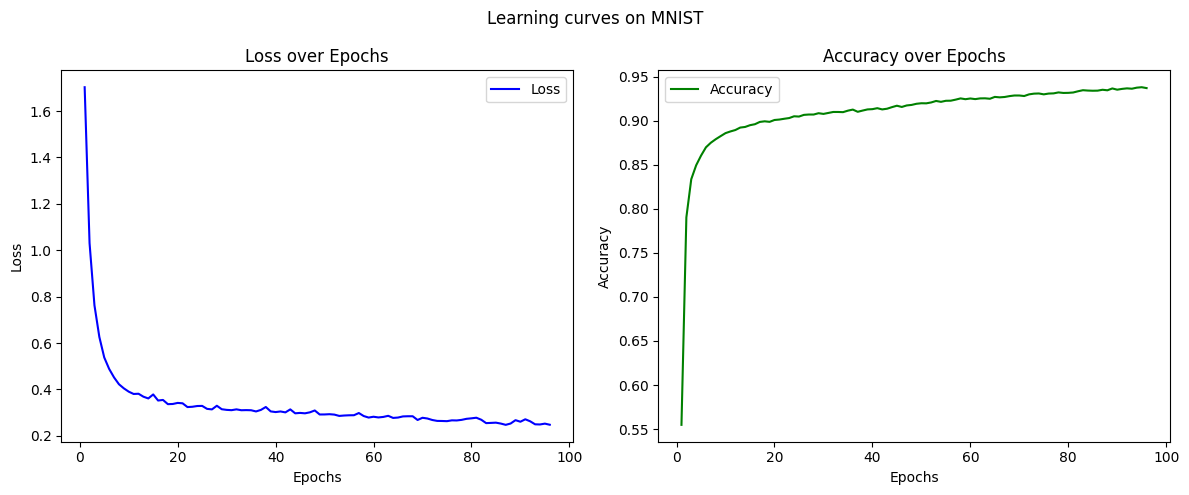

In [59]:
import math
import gc

gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_mnist,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_mnist.clients) * C),
    problem="mnist"
)

save_data(pool_mnist, losses, accuracies, elapsed, "sched_rand_400_mnist")

plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 36.40000000000025/36.40096607455098 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3100.242181777954 sec
Aggregating global model...
Server: Test acc: 0.1000, test loss: 2.3057, round time: 3140.321429491043 (sec)

Running round: 2 - Time elapsed: 3140.321431875229 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 38.00000000000027/38.04350858789837 [00:38<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3054.4962952136993 sec
Aggregating global model...
Server: Test acc: 0.1000, test loss: 2.6954, round time: 3096.3946771621704 (sec)

Running round: 3 - Time elapsed: 6236.717571973801 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 37.40000000000026/37.460106186961035 [00:38<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3090.6824769973755 sec
Aggregating global model...
Server: Test acc: 0.1260, test loss: 3.0774, round time: 3131.7543382644653 (sec)

Running round: 4 - Time elapsed: 9368.473495721817 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 38.20000000000027/38.21444368940868 [00:38<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3149.749188899994 sec
Aggregating global model...
Server: Test acc: 0.1122, test loss: 2.9986, round time: 3191.6602115631104 (sec)

Running round: 5 - Time elapsed: 12560.135234355927 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 38.00000000000027/38.0057321904623 [00:38<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3151.7042260169983 sec
Aggregating global model...
Server: Test acc: 0.1177, test loss: 3.1538, round time: 3193.4274327754974 (sec)

Running round: 6 - Time elapsed: 15753.564459323883 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 38.00000000000027/38.007021596225876 [00:38<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 3132.0250685214996 sec
Aggregating global model...
Server: Test acc: 0.1586, test loss: 2.8257, round time: 3173.6890790462494 (sec)

Running round: 7 - Time elapsed: 18927.255044460297 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 37.000000000000256/37.00730324831341 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 3068.391569375992 sec
Aggregating global model...
Server: Test acc: 0.1894, test loss: 2.6325, round time: 3109.105725288391 (sec)

Running round: 8 - Time elapsed: 22036.362498998642 seconds
Server requesting clients resources...
Selected clients for this round: 100
Distributing model...


Distributing model...: 100%|█████████▉| 37.600000000000264/37.64564961242548 [00:38<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 3084.157062292099 sec
Aggregating global model...
Server: Test acc: 0.2028, test loss: 2.6853, round time: 3125.431323289871 (sec)
Total selected clients: 800


,loss,accuracy,elapsed_time
0,2.305721,0.1000,3140.321429
1,2.695378,0.1000,3096.394677
2,3.077432,0.1260,3131.754338
3,2.998626,0.1122,3191.660212
4,3.153815,0.1177,3193.427433
5,2.825697,0.1586,3173.689079
6,2.632455,0.1894,3109.105725
7,2.685261,0.2028,3125.431323


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


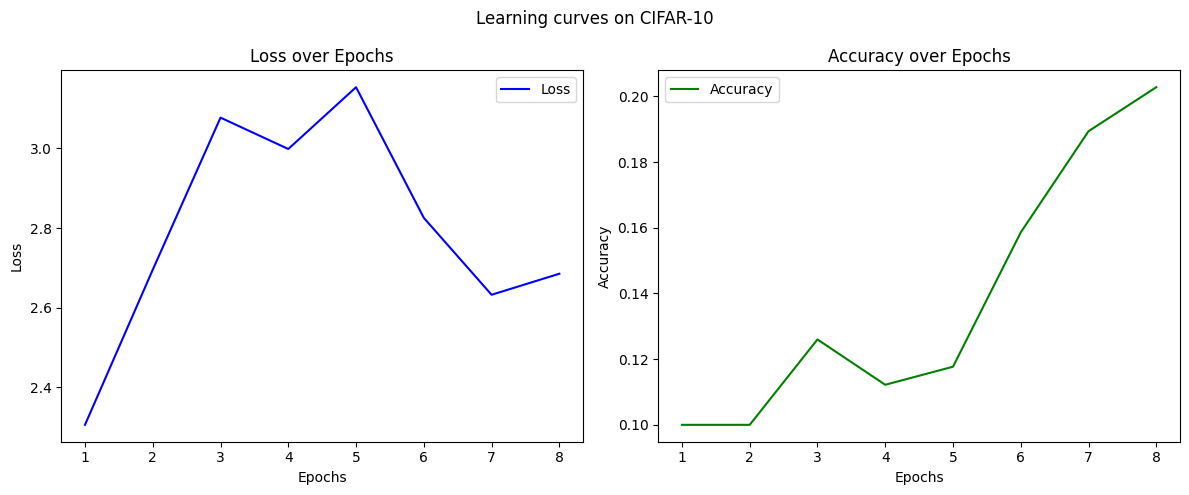

In [67]:
gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_cifar,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_cifar.clients) * C),
    problem="cifar"
)

save_data(pool_cifar, losses, accuracies, elapsed, "sched_rand_400_cifar")

plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")